Universidad del Valle de Guatemala ||
 Martin Amado 19020 -
 Juan Pablo Pineda 19087

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import gensim
import string
import re

from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
nltk.download(['stopwords', 'punkt', 'names', 'vader_lexicon'] )
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\reque\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\reque\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     C:\Users\reque\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\reque\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [121]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [122]:
print(train.shape)
print(test.shape)

(7613, 5)
(3263, 4)


## Analisis Exploratorio

C:\Users\reque\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'samples')

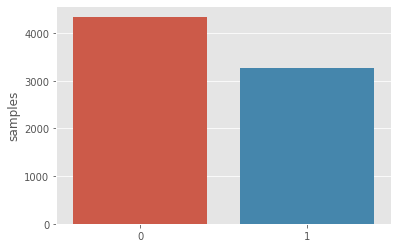

In [123]:
x = train.target.value_counts()
sns.barplot(x.index, x)
plt.gca().set_ylabel('samples')

Existen mas tweets que no hacen referencia a desastre (0) que aquellos que si hacen referencia a un desastre (1)

### Cantidad de caracteres en un tweet

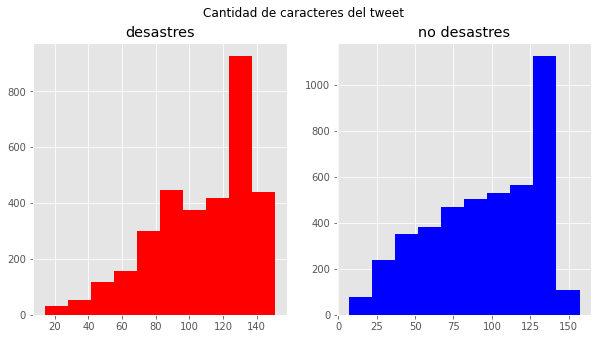

In [124]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
tweet_length = train[train['target']==1]['text'].str.len()
ax1.hist(tweet_length, color='red')
ax1.set_title('desastres')
tweet_length=train[train['target']==0]['text'].str.len()
ax2.hist(tweet_length, color='blue')
ax2.set_title('no desastres')
fig.suptitle('Cantidad de caracteres del tweet')
plt.show()

### Cantidad de palabras en el tweet

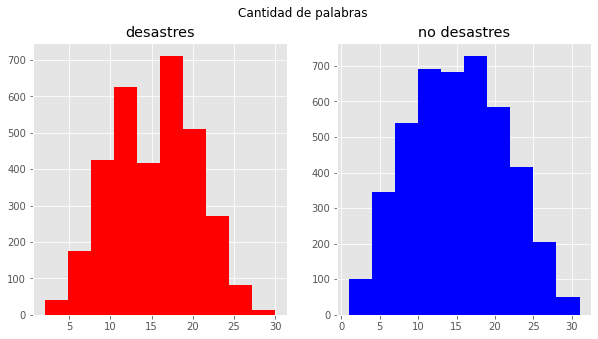

In [125]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_length=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_length,color='red')
ax1.set_title('desastres')
tweet_length=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_length,color='blue')
ax2.set_title('no desastres')
fig.suptitle('Cantidad de palabras')
plt.show()

### Promedio de longitud de las palabras

C:\Users\reque\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\reque\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Promedio de largo de las palabras en los tweets')

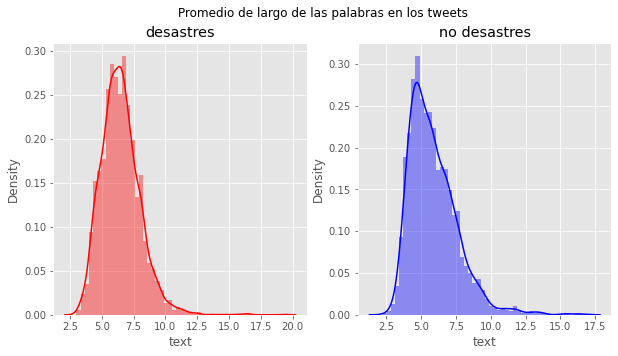

In [126]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('desastres')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='blue')
ax2.set_title('no desastres')
fig.suptitle('Promedio de largo de las palabras en los tweets')

In [127]:
def create_corpus(target):
    corpus=[]
    
    for x in train[train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

### Palabra vacias (stopwords) en los tweets 

#### Para no desastres

In [128]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

<BarContainer object of 10 artists>

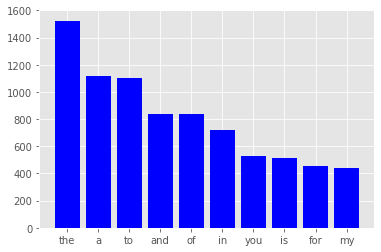

In [129]:
x,y=zip(*top)
plt.bar(x,y, color='blue')

#### Tweets de desastres

In [130]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

<BarContainer object of 10 artists>

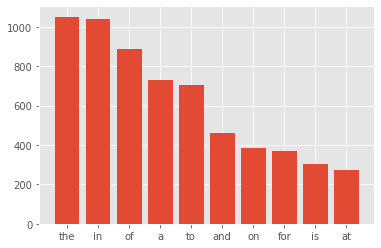

In [131]:
x,y=zip(*top)
plt.bar(x,y)

### Analisis de puntuacion

#### Desastres

In [132]:
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1

<Figure size 720x360 with 0 Axes>

<BarContainer object of 18 artists>

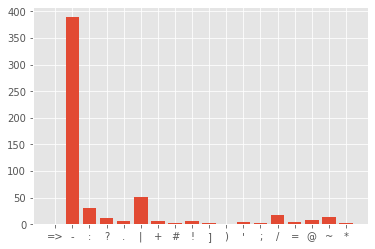

In [133]:
x,y=zip(*dic.items())
plt.bar(x,y)

#### No desastres

In [134]:
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1

<Figure size 720x360 with 0 Axes>

<BarContainer object of 20 artists>

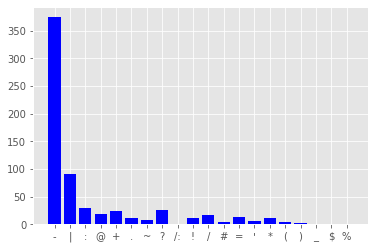

In [135]:
x,y=zip(*dic.items())
plt.bar(x,y,color='blue')

### Palabras comunes

<AxesSubplot:>

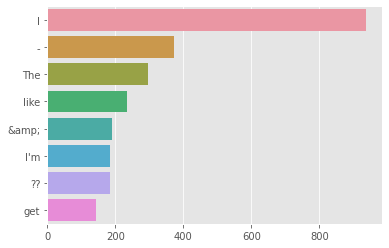

In [136]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

### Analisis ngramas

#### Bigrama (n=2)

In [137]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<AxesSubplot:>

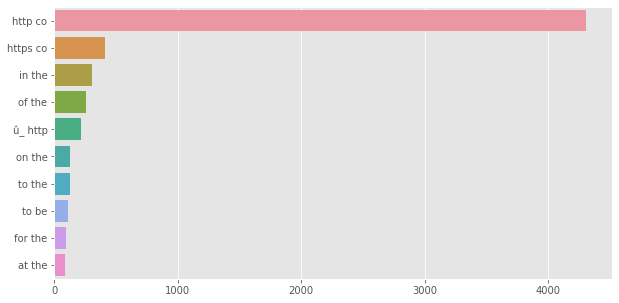

In [138]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(train['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

#### Trigrama

In [139]:
def get_top_tweet_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<AxesSubplot:>

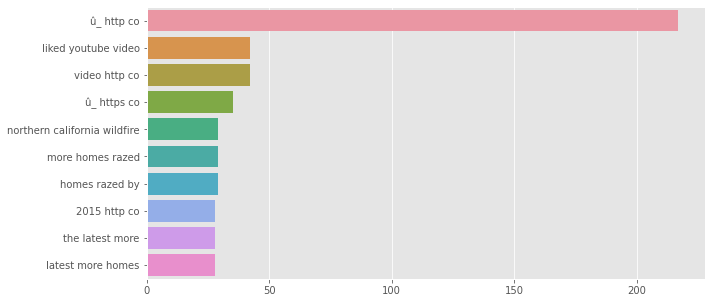

In [140]:
plt.figure(figsize=(10,5))
top_tweet_trigrams=get_top_tweet_trigrams(train['text'])[:10]
x,y=map(list,zip(*top_tweet_trigrams))
sns.barplot(x=y,y=x)

## Limpieza de los datos

In [141]:
union = pd.concat([train, test])
union.shape

(10876, 5)

### Quitar URLs

In [142]:
def remove_URL(text):
  url = re.compile(r'https?://\S+|www\.\S+')
  return url.sub(r'', text)

In [143]:
union['text'] = union['text'].apply(lambda x : remove_URL(x))

### Quitar tags HTML

In [144]:
def remove_HTML(text):
  html = re.compile(r'<.*?>')
  return html.sub(r'', text)

In [145]:
union['text'] = union['text'].apply(lambda x : remove_HTML(x))

### Quitar emojis

In [146]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [147]:
union['text'] = union['text'].apply(lambda x : remove_emoji(x))

### Quitar puntuacion

In [148]:
def remove_point(text):
  table = str.maketrans('', '', string.punctuation)
  return text.translate(table)

In [149]:
union['text'] = union['text'].apply(lambda x : remove_point(x))

### Corregir errores de ortografia

In [150]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spelling(text):
  corrected_str = []
  misspelled_str = spell.unknown(text.split())
  for word in text.split():
    if word in misspelled_str:
      corrected_str.append(spell.correction(word))
    else:
      corrected_str.append(word)
  return " ".join(corrected_str)

In [151]:
# union['text'] = union['text'].apply(lambda x : correct_spelling(x))

## Analisis post limpieza

### Palabras comunes

<AxesSubplot:>

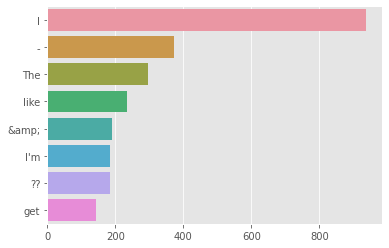

In [152]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

### Analisis ngramas

#### Bigrama (n=2)

In [153]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<AxesSubplot:>

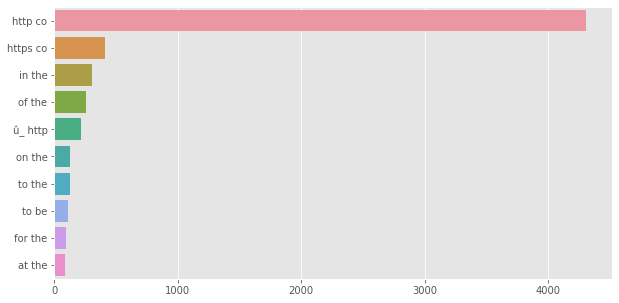

In [154]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(train['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

#### Trigrama

In [155]:
def get_top_tweet_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<AxesSubplot:>

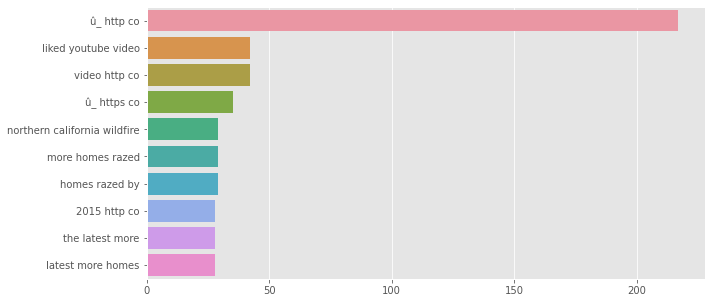

In [156]:
plt.figure(figsize=(10,5))
top_tweet_trigrams=get_top_tweet_trigrams(train['text'])[:10]
x,y=map(list,zip(*top_tweet_trigrams))
sns.barplot(x=y,y=x)

In [157]:
stopwords = nltk.corpus.stopwords.words("english")

## Analisis polaridad

Para determinar las palabras positivas, negativas y neutras, se utiliza Vader Lexicon (vader_lexicon) de la libreria NLTK.

### Determinacion de valor del tweet

In [158]:
sia = SentimentIntensityAnalyzer()

In [159]:
def getScoreText(text):
    scoreObject = sia.polarity_scores(text)
    score = scoreObject['compound']
    return score

In [160]:
train['score'] = train['text'].apply(lambda x : getScoreText(x))
union['score'] = union['text'].apply(lambda x : getScoreText(x))

### De acuerdo al valor asignado, se definen los tweets como negativos, neutrales o positivos

In [161]:
#rangos de score
def setPolarity(score):
    if score < -0.33:
        return 'negative'
    elif score > 0.33:
        return 'positive'
    else:
        return 'neutral'

In [162]:
train['polarity'] = train['score'].apply(lambda x : setPolarity(x))
union['polarity'] = union['score'].apply(lambda x : setPolarity(x))

### Determinacion de los tweets mas negativos y mas positivos

#### 10 tweets mas negativos

In [163]:
train.sort_values(by=['score']).head(10)

,id,keyword,location,text,target,score,polarity
7472,10689,wreck,NaN,wreck? wreck wreck wreck wreck wreck wreck wre...,0,-0.9883,negative
6414,9172,suicide%20bomber,NaN,@Abu_Baraa1 Suicide bomber targets Saudi mosqu...,1,-0.9686,negative
6411,9166,suicide%20bomber,NaN,Suicide bomber kills 15 in Saudi security site...,1,-0.9623,negative
6393,9137,suicide%20bomb,Worldwide,? 19th Day Since 17-Jul-2015 -- Nigeria: Suici...,1,-0.9595,negative
6407,9159,suicide%20bomber,Worldwide,17 killed in SÛªArabia mosque suicide bombing...,1,-0.9552,negative
2932,4213,drowned,Pembroke NH,at the lake \r\n*sees a dead fish*\r\nme: poor...,0,-0.9549,negative
472,682,attack,"portland, oregon",illegal alien released by Obama/DHS 4 times Ch...,1,-0.9538,negative
1540,2225,chemical%20emergency,"Las Vegas, Nevada",Bomb Crash Loot Riot Emergency Pipe Bomb Nucle...,1,-0.9524,negative
6818,9765,trapped,10 Steps Ahead. Cloud 9,Bomb head? Explosive decisions dat produced mo...,1,-0.9500,negative
6930,9940,trouble,NaN,@cspan #Prez. Mr. President you are the bigges...,1,-0.9493,negative


De los 10 tweets mas negativos, 8 de ellos hacen referencia a un desastre real

#### 10 tweets mas positivos

In [164]:
train.sort_values(by=['score'], ascending=False).head(10)

,id,keyword,location,text,target,score,polarity
6992,10028,twister,NaN,Check out 'Want Twister Tickets AND A VIP EXPE...,0,0.9730,positive
6534,9345,survived,"Texas, USA",@thoutaylorbrown I feel like accidents are jus...,0,0.9564,positive
6292,8989,storm,NaN,TodayÛªs storm will pass; let tomorrowÛªs li...,1,0.9471,positive
3382,4844,evacuation,"Renfrew, Scotland",@batfanuk we enjoyed the show today. Great fun...,0,0.9423,positive
3163,4541,emergency,"Renfrew, Scotland",@batfanuk we enjoyed the show today. Great fun...,0,0.9423,positive
6778,9710,tragedy,NaN,Maaaaan I love Love Without Tragedy by @rihann...,0,0.9394,positive
6295,8994,stretcher,NaN,Free Ebay Sniping RT? http://t.co/B231Ul1O1K L...,0,0.9376,positive
2457,3525,derailment,UK,@Raishimi33 :) well I think that sounds like a...,1,0.9356,positive
1001,1453,body%20bagging,NaN,I'm not a Drake fan but I enjoy seeing him bod...,0,0.9345,positive
6560,9386,survived,Puerto Rico,@duchovbutt @Starbuck_Scully @MadMakNY @davidd...,0,0.9344,positive


De los 10 tweets mas positivos, 8 de ellos hacen no referencia a un desastre real

### Categorizacion negatividad/desastre

In [165]:
grouped = train.groupby(['polarity', 'target'])
grouped.size()

polarity  target
negative  0         1428
          1         1603
neutral   0         1908
          1         1316
positive  0         1006
          1          352
dtype: int64

Con los resultados obtenidos: <br>  - Para una polaridad negativa, si es un indicador para saber si se trata de un desastre. <br>  - Para una polaridad positiva, es un indicador para saber si se trata de un no desastre <br>  - Para una polaridad neutral, no es el mejor indicador, pero si puede dar indicios

## Modelo

In [166]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [167]:
corpus=create_corpus(union)

100%|██████████| 10876/10876 [00:01<00:00, 5504.53it/s]


In [168]:
embedding_dict={}
with open('./glove.6B.100d.txt','r', encoding='utf-8') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [169]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)
tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [170]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 20342


In [171]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 20342/20342 [00:00<00:00, 184541.47it/s]


#### Armando el modelo

In [172]:
from cProfile import run


model=Sequential()
embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix), input_length=MAX_LEN,trainable=False)
model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
optimzer=Adam(learning_rate=1e-5)
model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'], run_eagerly=True)

In [173]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 100)           2034300   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 50, 100)          0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 64)                42240     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,076,605
Trainable params: 42,305
Non-trainable params: 2,034,300
_________________________________________________________________


In [174]:
train=tweet_pad[:union.shape[0]]
test=tweet_pad[union.shape[0]:]

In [175]:
X_train,X_test,y_train,y_test = train_test_split(train,union['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (9244, 50)
Shape of Validation  (1632, 50)


In [176]:
history = model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)

Epoch 1/15
2311/2311 - 1014s - loss: nan - accuracy: 0.3981 - val_loss: nan - val_accuracy: 0.4044 - 1014s/epoch - 439ms/step
Epoch 2/15
2311/2311 - 939s - loss: nan - accuracy: 0.3983 - val_loss: nan - val_accuracy: 0.4044 - 939s/epoch - 406ms/step
Epoch 3/15
2311/2311 - 867s - loss: nan - accuracy: 0.3983 - val_loss: nan - val_accuracy: 0.4044 - 867s/epoch - 375ms/step
Epoch 4/15
2311/2311 - 894s - loss: nan - accuracy: 0.3983 - val_loss: nan - val_accuracy: 0.4044 - 894s/epoch - 387ms/step
Epoch 5/15
2311/2311 - 889s - loss: nan - accuracy: 0.3983 - val_loss: nan - val_accuracy: 0.4044 - 889s/epoch - 385ms/step
Epoch 6/15
2311/2311 - 1017s - loss: nan - accuracy: 0.3983 - val_loss: nan - val_accuracy: 0.4044 - 1017s/epoch - 440ms/step
Epoch 7/15
2311/2311 - 902s - loss: nan - accuracy: 0.3983 - val_loss: nan - val_accuracy: 0.4044 - 902s/epoch - 390ms/step
Epoch 8/15
2311/2311 - 928s - loss: nan - accuracy: 0.3983 - val_loss: nan - val_accuracy: 0.4044 - 928s/epoch - 401ms/step
Epoc

In [177]:
sample_sub = pd.read_csv('./predictions.csv')

In [ ]:
y_pre=model.predict(test)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)